# Image Captioning - Data Exploration

This notebook explores the Flickr8k dataset for the image captioning task. We will:

1. Download and prepare the dataset
2. Explore the images and captions
3. Analyze the distribution of caption lengths
4. Examine the vocabulary
5. Visualize some sample images with their captions

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import nltk
from collections import Counter
from tqdm import tqdm
import re
import string
import seaborn as sns
import random

# Add project root to path
sys.path.append('..')

# Import project modules
from data.download_flickr import download_flickr8k
from utils.vocabulary import Vocabulary, build_vocab_from_captions
from utils.metrics import calculate_bleu

## 1. Download and Prepare the Dataset

In [2]:
# Download and prepare the Flickr8k dataset
data_dir = '../data'
paths = download_flickr8k(data_dir)

File already exists at ../data\flickr8k\Flickr8k_Dataset.zip. Skipping download.
File already exists at ../data\flickr8k\Flickr8k_text.zip. Skipping download.


Extracting Flickr8k_text.zip: 100%|███████████████████████████████████████████████████| 10/10 [00:00<00:00, 188.43it/s]


Processed captions saved to ../data\flickr8k\processed\captions.csv


Organizing images: 100%|█████████████████████████████████████████████████████████| 8091/8091 [00:00<00:00, 9432.37it/s]


Images organized in ../data\flickr8k\processed\images
Created data splits: train (30000 captions), val (5000 captions), test (5000 captions)


In [3]:
# Load the captions
captions_path = os.path.join(paths['processed_path'], 'captions.csv')
captions_df = pd.read_csv(captions_path)

# Display the first few rows
captions_df.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


## 2. Explore the Images and Captions

In [4]:
# Count unique images and total captions
unique_images = captions_df['image'].nunique()
total_captions = len(captions_df)

print(f"Total number of images: {unique_images}")
print(f"Total number of captions: {total_captions}")
print(f"Average captions per image: {total_captions / unique_images:.2f}")

Total number of images: 8092
Total number of captions: 40460
Average captions per image: 5.00


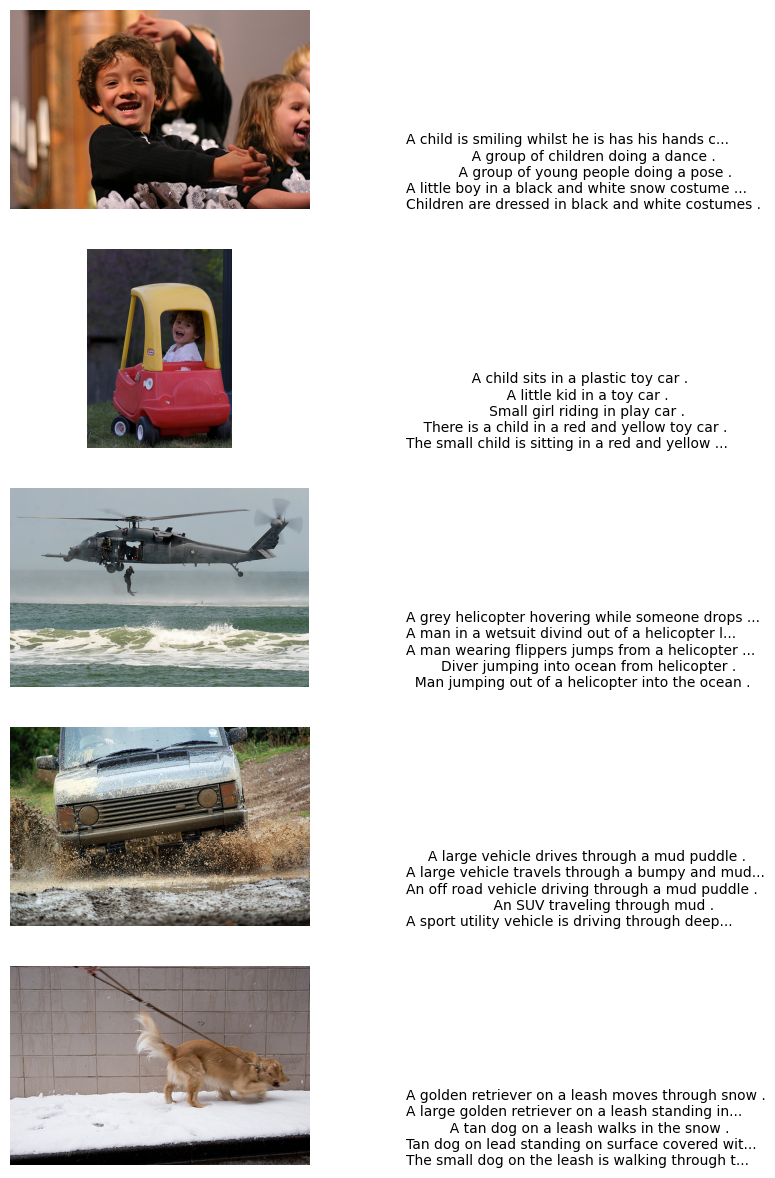

In [5]:

def display_images_with_captions(captions_df, images_dir, num_samples=5):
    selected_images = random.choices( list(set(captions_df['image'])) , k = num_samples )
    fig  , axes = plt.subplots( num_samples ,2   , figsize = (10 , 15 ) ) # int(num_samples/c)
    axes = axes.flatten()
    for i in range(len(selected_images)):
        image = selected_images[i]
        captions = captions_df[captions_df['image']==image]['caption']
        formatted_caption = captions.to_string(index = False )
        axes[i*2].imshow(Image.open(os.path.join(images_dir , image)))
        axes[i*2+1].text( 0 ,0  , formatted_caption )
        axes[i*2].axis('off')
        axes[i*2+1].axis('off')
    
# Display some sample images with their captions
images_dir = os.path.join(paths['processed_path'], 'images')
display_images_with_captions(captions_df, images_dir )

## 3. Analyze Caption Lengths

In [7]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Aha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [8]:

def tokenize(text):
    text = text.lower() 
    text = re.sub(r'[^\w\s]', '', text)
    tokens = nltk.word_tokenize(text) # Lemmatization ???
    return tokens

# Calculate caption lengths
captions_df['tokens'] = captions_df['caption'].apply(tokenize)
captions_df['length'] = captions_df['tokens'].apply(len)

# Display statistics
caption_lengths = captions_df['length']
print(f"Min length: {caption_lengths.min()}")
print(f"Max length: {caption_lengths.max()}")
print(f"Mean length: {caption_lengths.mean():.2f}")
print(f"Median length: {caption_lengths.median()}")
print(f"90th percentile length: {caption_lengths.quantile(0.9)}")
print(f"95th percentile length: {caption_lengths.quantile(0.95)}")

Min length: 1
Max length: 36
Mean length: 10.79
Median length: 10.0
90th percentile length: 16.0
95th percentile length: 18.0


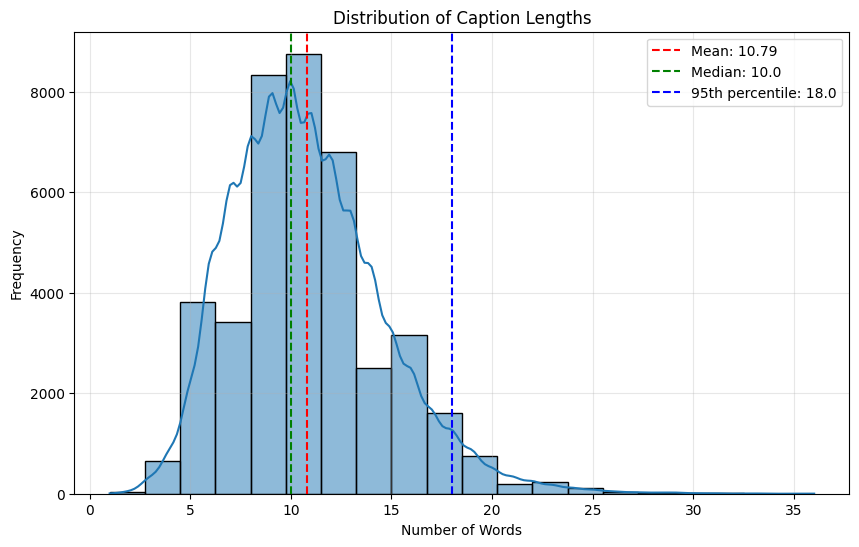

In [9]:
# Plot the distribution of caption lengths
plt.figure(figsize=(10, 6))
sns.histplot(caption_lengths, bins=20, kde=True)
plt.axvline(x=caption_lengths.mean(), color='r', linestyle='--', label=f'Mean: {caption_lengths.mean():.2f}')
plt.axvline(x=caption_lengths.median(), color='g', linestyle='--', label=f'Median: {caption_lengths.median()}')
plt.axvline(x=caption_lengths.quantile(0.95), color='b', linestyle='--', label=f'95th percentile: {caption_lengths.quantile(0.95)}')
plt.title('Distribution of Caption Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 4. Examine the Vocabulary

In [10]:
# Count word frequencies
all_tokens = [token for tokens in captions_df['tokens'] for token in tokens]
word_freq = Counter(all_tokens)

# Display statistics
print(f"Total vocabulary size: {len(word_freq)}")
print(f"Number of words appearing only once: {sum(1 for count in word_freq.values() if count == 1)}")

Total vocabulary size: 8827
Number of words appearing only once: 3608


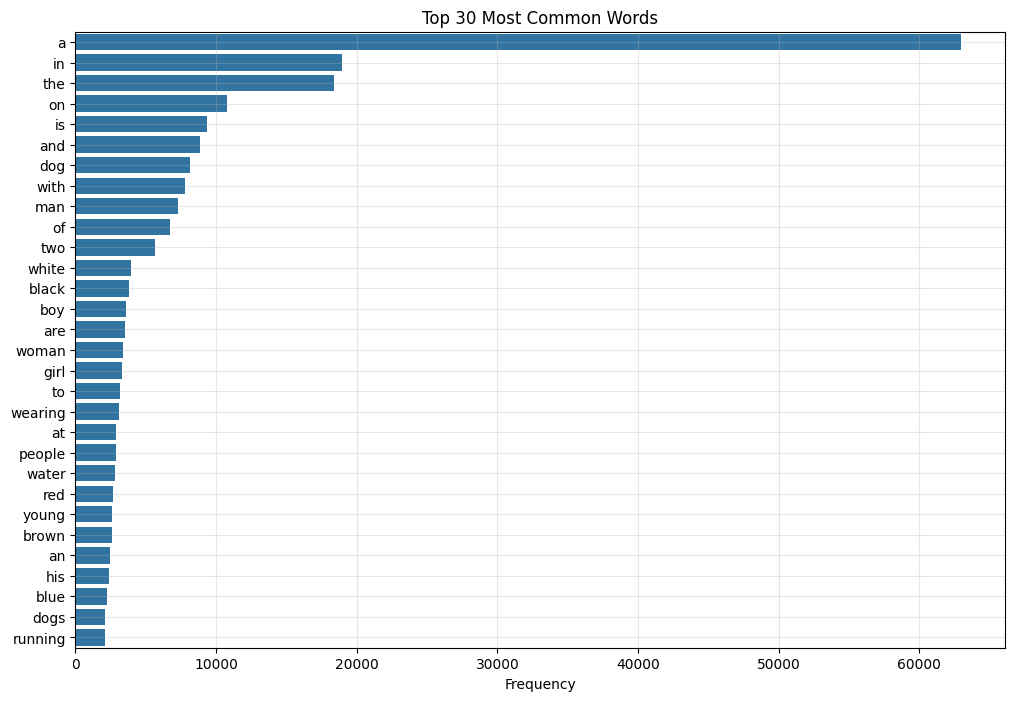

In [11]:
# Plot the most common words
top_n = 30
most_common = word_freq.most_common(top_n)
words, counts = zip(*most_common)

plt.figure(figsize=(12, 8))
sns.barplot(x=list(counts), y=list(words))
plt.title(f'Top {top_n} Most Common Words')
plt.xlabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

In [12]:

thresholds = [1, 2, 3, 5, 10]
coverage = []

word_counts = Counter(all_tokens)
total_tokens = len(all_tokens)


for threshold in thresholds:
    
    frequent_words = [word for word, count in word_counts.items() if count >= threshold]
    
    vocab_size = len(frequent_words)
    covered_tokens = sum(count for word, count in word_counts.items() if count >= threshold)
    coverage_pct = (covered_tokens / total_tokens) * 100
    
    coverage.append((threshold, vocab_size, coverage_pct))
    
    print(f"Threshold: {threshold}, Vocabulary size: {vocab_size}, Coverage: {coverage_pct:.2f}%")


Threshold: 1, Vocabulary size: 8827, Coverage: 100.00%
Threshold: 2, Vocabulary size: 5219, Coverage: 99.17%
Threshold: 3, Vocabulary size: 4093, Coverage: 98.66%
Threshold: 5, Vocabulary size: 2991, Coverage: 97.80%
Threshold: 10, Vocabulary size: 1955, Coverage: 96.24%


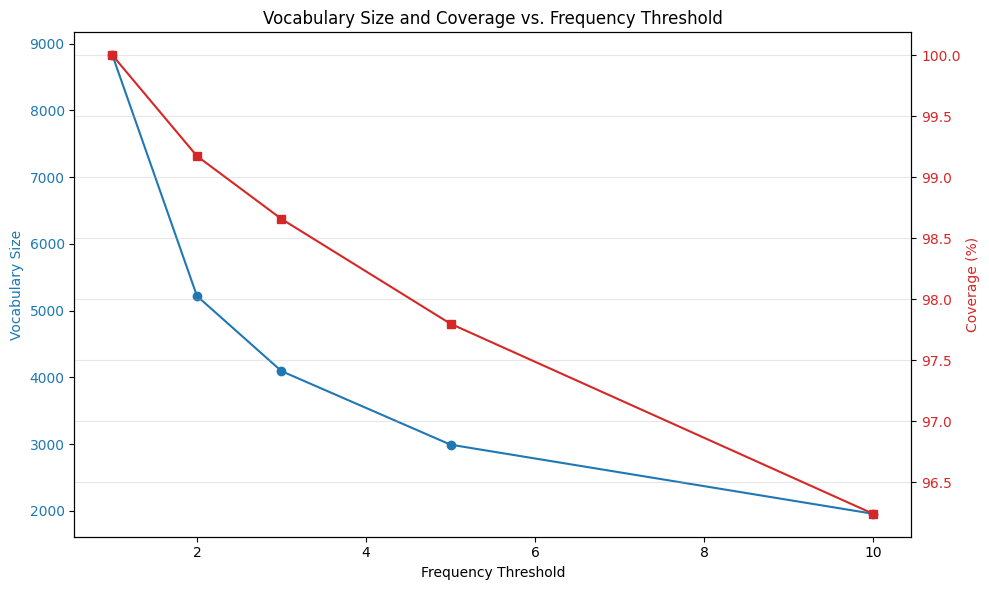

In [13]:
# Plot vocabulary coverage
thresholds, vocab_sizes, coverages = zip(*coverage)

fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot vocabulary size
color = 'tab:blue'
ax1.set_xlabel('Frequency Threshold')
ax1.set_ylabel('Vocabulary Size', color=color)
ax1.plot(thresholds, vocab_sizes, 'o-', color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create second y-axis for coverage
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Coverage (%)', color=color)
ax2.plot(thresholds, coverages, 's-', color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Vocabulary Size and Coverage vs. Frequency Threshold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 5. Build and Save the Vocabulary

In [14]:
# Build and save the vocabulary
freq_threshold = 5  # Words appearing less than 5 times are considered rare
vocab = build_vocab_from_captions(captions_path, paths['processed_path'], freq_threshold=freq_threshold)

print(f"Built vocabulary with {len(vocab)} words")

Vocabulary built with 2986 words
Saved to ../data\flickr8k\processed\vocabulary.pkl
Built vocabulary with 2986 words


## 6. Explore Data Splits

In [15]:
# Load data splits
train_df = pd.read_csv(os.path.join(paths['processed_path'], 'train_data.csv'))
val_df = pd.read_csv(os.path.join(paths['processed_path'], 'val_data.csv'))
test_df = pd.read_csv(os.path.join(paths['processed_path'], 'test_data.csv'))

# Display statistics
print(f"Training set: {train_df['image'].nunique()} images, {len(train_df)} captions")
print(f"Validation set: {val_df['image'].nunique()} images, {len(val_df)} captions")
print(f"Test set: {test_df['image'].nunique()} images, {len(test_df)} captions")

Training set: 6000 images, 30000 captions
Validation set: 1000 images, 5000 captions
Test set: 1000 images, 5000 captions


## 7. Check Image Dimensions

In [16]:
# Check image dimensions for a sample of images
# TODO: Implement a function to analyze image dimensions in the dataset
# This function should:
# 1. Get a sample of image files from the directory
# 2. Load each image and extract its dimensions
# 3. Return a DataFrame with width and height columns for analysis
def check_image_dimensions(images_dir, num_samples=100):
    sampled_images = random.choices(os.listdir(images_dir) , k = num_samples) 
    dim = []
    for image in sampled_images:
        
        dim.append( Image.open(os.path.join( images_dir , image)).size   )
    dim_df = pd.DataFrame(dim, columns=['width'  , 'height']) 
    return dim_df

# Check dimensions
image_dimensions = check_image_dimensions(images_dir)

# Display statistics
print("Image dimension statistics:")
print(image_dimensions.describe())

Image dimension statistics:
           width      height
count  100.00000  100.000000
mean   448.71000  403.220000
std     76.25665   80.196801
min    251.00000  253.000000
25%    343.25000  333.000000
50%    500.00000  375.000000
75%    500.00000  500.000000
max    500.00000  500.000000


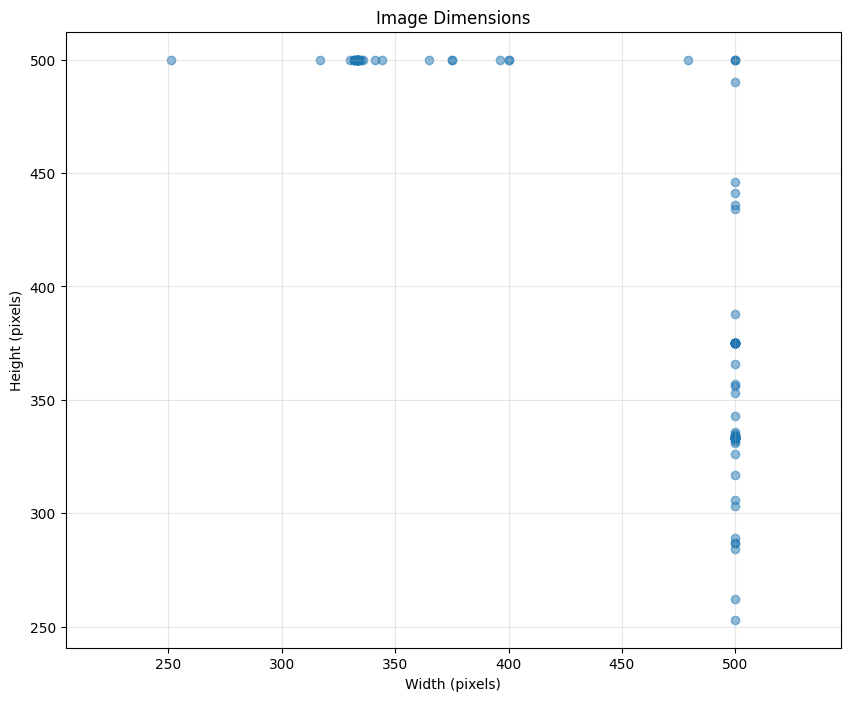

In [17]:
# Plot image dimensions
plt.figure(figsize=(10, 8))
plt.scatter(image_dimensions['width'], image_dimensions['height'], alpha=0.5)
plt.title('Image Dimensions')
plt.xlabel('Width (pixels)')
plt.ylabel('Height (pixels)')
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.show()

## BLEU score of captoins with itself 

In [19]:
references = []
hypotheses = []
for i in range(len(captions_df)):
    hyp = captions_df.iloc[i]['tokens']
    ref = captions_df[captions_df['image']== captions_df.iloc[i]['image']]['tokens']
    ref = list(ref)
    for r in ref :
        references.append([r])
        hypotheses.append(hyp)

In [22]:
calculate_bleu(references , hypotheses , vocab ) 

[[['a', 'child', 'in', 'a', 'pink', 'dress', 'is', 'climbing', 'up', 'a', 'set', 'of', 'stairs', 'in', 'an', 'entry', 'way']], [['a', 'girl', 'going', 'into', 'a', 'wooden', 'building']], [['a', 'little', 'girl', 'climbing', 'into', 'a', 'wooden', 'playhouse']]] [['a', 'child', 'in', 'a', 'pink', 'dress', 'is', 'climbing', 'up', 'a', 'set', 'of', 'stairs', 'in', 'an', 'entry', 'way'], ['a', 'child', 'in', 'a', 'pink', 'dress', 'is', 'climbing', 'up', 'a', 'set', 'of', 'stairs', 'in', 'an', 'entry', 'way'], ['a', 'child', 'in', 'a', 'pink', 'dress', 'is', 'climbing', 'up', 'a', 'set', 'of', 'stairs', 'in', 'an', 'entry', 'way']]
bleu_scores [0.50056626594341, 0.39104937815708385, 0.33307755779054093, 0.29922989347971934]


[0.50056626594341,
 0.39104937815708385,
 0.33307755779054093,
 0.29922989347971934]

## Summary

In this notebook, we have explored the Flickr8k dataset for image captioning. We have:

1. Downloaded and prepared the dataset
2. Explored the images and captions
3. Analyzed the distribution of caption lengths
4. Examined the vocabulary and its coverage
5. Built and saved the vocabulary
6. Explored the data splits
7. Checked image dimensions

This exploration gives us a good understanding of the dataset and helps us make informed decisions when designing our image captioning model.